In [58]:
!git clone https://github.com/kaapthijs/DMT-A1.git


Cloning into 'DMT-A1'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 86 (delta 27), reused 36 (delta 11), pack-reused 31
Receiving objects: 100% (86/86), 30.10 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [59]:
import os
os.chdir('DMT-A1')

In [3]:
import pandas as pd
import numpy as np
from feature_engineering import create_features,select_features
import random

#SEED = np.random.randint(100)
SEED = 60
np.random.seed(SEED), random.seed(SEED)
print(f"SEED: {SEED}")
#pd.set_option('future.no_silent_downcasting', True)
dataset = pd.read_csv('./cleaned_dataset.csv')
# Creating features
X, y = create_features(dataset,window_size=1)

SEED: 60


In [60]:
X.shape, y.shape

((1304, 32), (1304, 1))

In [228]:
X.shape, y.shape
X['mood_final'] = y
X.shape, y.shape

((1304, 33), (1304, 1))

In [229]:
#create sequences for the LSTM
def create_sequences(X, y, sequence_length=5):
    X_final= []
    y_final = []
    for i in range(len(X) - sequence_length):
        X_final.append(X.iloc[i:i + sequence_length, :].values)
        y_final.append(y.iloc[i:i + sequence_length])
    return np.array(X_final), np.array(y_final)

X_seq, y_seq = create_sequences(X, y, sequence_length=5)

In [230]:
from sklearn.model_selection import train_test_split

#custom train test split for sequential data
def train_test_split_custom(data, train_size=0.8):
    split_idx = int(len(data) * train_size)
    train = data[:split_idx]
    test = data[split_idx:]
    return train, test


'''
X_train, X_test = train_test_split(X_seq, train_size=0.75, stratify = (y_seq[:,-1] > 7.5).astype(int))
y_train, y_test = train_test_split(y_seq, train_size=0.75,stratify = (y_seq[:,-1] > 7.5).astype(int))
X_train.shape,y_train.shape, X_test.shape,y_test.shape
'''
X_train, X_test = train_test_split_custom(X_seq, train_size=0.8)
y_train, y_test = train_test_split_custom(y[5:], train_size=0.8)
X_train.shape,y_train.shape, X_test.shape,y_test.shape



((1039, 5, 33), (1039, 1), (260, 5, 33), (260, 1))

In [231]:
#normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1,X_train.shape[2]))

X_train_scaled = scaler.transform(np.reshape(X_train, (-1, X_train.shape[2])))
X_test_scaled = scaler.transform(np.reshape(X_test, (-1, X_test.shape[2])))

# Reshape back to the original dimensions
X_train_scaled = np.reshape(X_train_scaled, X_train.shape)
X_test_scaled = np.reshape(X_test_scaled, X_test.shape)

In [232]:
##Classification task y_train discritizer
y_train_binary = (y_train > 7.5).astype(int)
y_test_binary = (y_test > 7.5).astype(int)

In [233]:
X_train_scaled.shape,y_train_binary.shape,X_test_scaled.shape,y_test_binary.shape

((1039, 5, 33), (1039, 1), (260, 5, 33), (260, 1))

In [234]:
from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import GRU



timesteps = X_train_scaled.shape[1]  # Number of timesteps in the input/output sequence
features = X_train_scaled.shape[2] # Number of features in the input
output_units = 1  # Output dimension (1 for binary classification at each timestep)




model1 = Sequential([
    LSTM(10, input_shape=(timesteps, features)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model2 = Sequential([
    LSTM(50, return_sequences=True,input_shape=(timesteps, features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model3 = Sequential([
    Bidirectional(LSTM(50), input_shape=(timesteps, features)),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model4 = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, features)),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dense(1, activation='sigmoid')
])
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model5 = Sequential([
    SimpleRNN(10, input_shape=(timesteps, features)),  # Smaller RNN unit
    Dense(1, activation='sigmoid')
])
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model6 = Sequential([
    GRU(50, input_shape=(timesteps, features)),  # Similar to LSTM but usually faster
    Dense(1, activation='sigmoid')
])
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



model7 = Sequential([
    SimpleRNN(50, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(50),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model8 = Sequential([
    Bidirectional(SimpleRNN(50), input_shape=(timesteps, features)),
    Dense(1, activation='sigmoid')
])
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])










In [235]:
model = model1
model.summary()



Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_110 (LSTM)             (None, 10)                1760      
                                                                 
 dropout_37 (Dropout)        (None, 10)                0         
                                                                 
 dense_101 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1771 (6.92 KB)
Trainable params: 1771 (6.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [236]:
class_weight_dict = {0: 1, 1: 4}

In [242]:
history = model.fit(
    X_train_scaled,
    y_train_binary,            # Training data and labels
    epochs=10,                   # Number of epochs to train for
    batch_size=16,               # Batch size for training
    validation_split=0.3,        # Fraction of data to use for validation
    verbose=1,                   # Show detailed progress in the output
    class_weight = class_weight_dict
)


Epoch 1/10
46/46 [==============================] - 1s 13ms/step - loss: 1.0610 - accuracy: 0.6410 - val_loss: 0.6134 - val_accuracy: 0.7532
Epoch 2/10
46/46 [==============================] - 1s 11ms/step - loss: 1.0528 - accuracy: 0.6204 - val_loss: 0.6744 - val_accuracy: 0.6346
Epoch 3/10
46/46 [==============================] - 0s 11ms/step - loss: 1.0392 - accuracy: 0.5997 - val_loss: 0.6184 - val_accuracy: 0.7404
Epoch 4/10
46/46 [==============================] - 1s 13ms/step - loss: 1.0185 - accuracy: 0.6547 - val_loss: 0.6272 - val_accuracy: 0.7115
Epoch 5/10
46/46 [==============================] - 1s 13ms/step - loss: 1.0012 - accuracy: 0.6547 - val_loss: 0.6723 - val_accuracy: 0.6218
Epoch 6/10
46/46 [==============================] - 1s 18ms/step - loss: 0.9860 - accuracy: 0.7015 - val_loss: 0.6167 - val_accuracy: 0.7115
Epoch 7/10
46/46 [==============================] - 0s 10ms/step - loss: 0.9998 - accuracy: 0.6754 - val_loss: 0.6131 - val_accuracy: 0.7019
Epoch 8/10
46

In [243]:
y_pred_probs = model.predict(X_test_scaled)  # Get probability scores
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

9/9 [==============================] - 0s 3ms/step


In [244]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test_binary, y_pred, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.71      0.78      0.74       158
     Class 1       0.59      0.50      0.54       102

    accuracy                           0.67       260
   macro avg       0.65      0.64      0.64       260
weighted avg       0.66      0.67      0.66       260



9/9 [==============================] - 0s 3ms/step


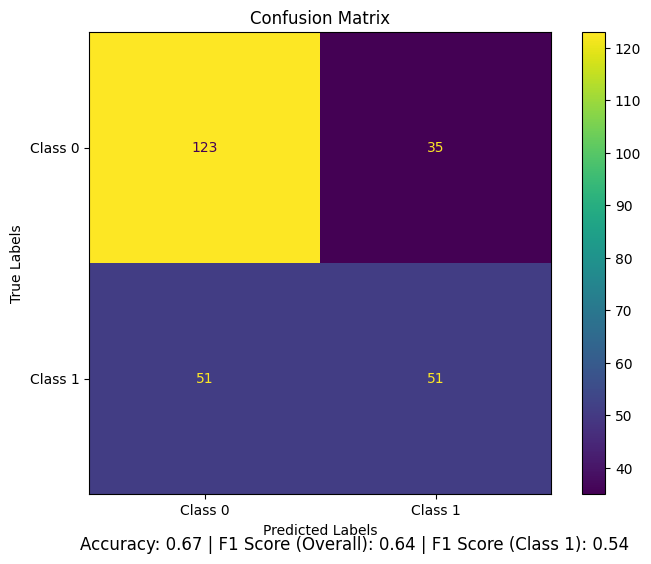

In [245]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

# Prediction and metrics calculation
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
accuracy = accuracy_score(y_test_binary, y_test_pred)
f1 = f1_score(y_test_binary, y_test_pred, average='macro')
f1_class1 = f1_score(y_test_binary, y_test_pred, pos_label=1)

# Confusion matrix plotting
cm = confusion_matrix(y_test_binary, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Adding text below the confusion matrix
plt.gcf().text(0.5, 0.01, f'Accuracy: {accuracy:.2f} | F1 Score (Overall): {f1:.2f} | F1 Score (Class 1): {f1_class1:.2f}', ha='center', va='bottom', fontsize=12)
plt.show()


Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_105 (LSTM)             (None, 10)                1720      
                                                                 
 dropout_36 (Dropout)        (None, 10)                0         
                                                                 
 dense_97 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1731 (6.76 KB)
Trainable params: 1731 (6.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
59/59 [==============================] - 4s 18ms/step - loss: 1.1311 - accuracy: 0.5465 - val_loss: 0.6727 - val_accuracy: 0.6058
Epoch 2/5
59/59 [==============================] - 0s 5ms/step - loss: 1.1071 - accuracy: 0.5209 - val_loss: 0.6628 - val_accuracy: 0.6635
Epoch 

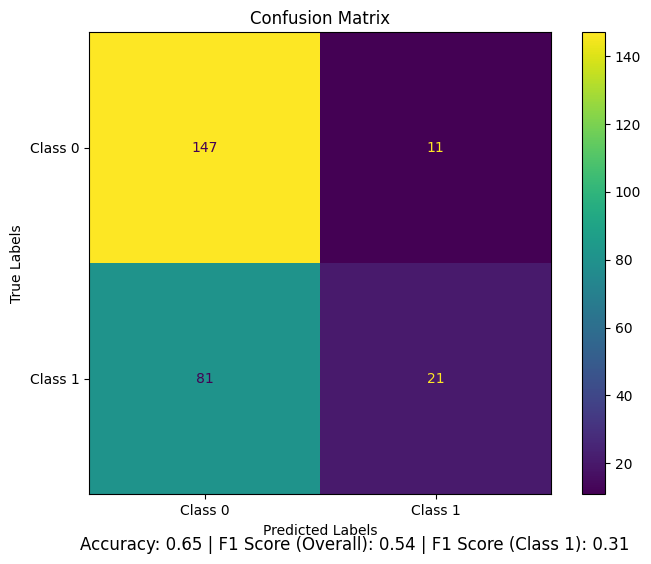

In [227]:
###########Combined into full code##################

from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

timesteps = X_train_scaled.shape[1]  # Number of timesteps in the input/output sequence
features = X_train_scaled.shape[2] # Number of features in the input
output_units = 1  # Output dimension (1 for binary classification at each timestep)




model1 = Sequential([
    LSTM(10, input_shape=(timesteps, features)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model2 = Sequential([
    LSTM(50, return_sequences=True,input_shape=(timesteps, features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model3 = Sequential([
    Bidirectional(LSTM(50), input_shape=(timesteps, features)),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model4 = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, features)),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dense(1, activation='sigmoid')
])
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])






model = model1
epochs = 5
model.summary()



class_weight_dict = {0: 1, 1: 4.5}


history = model.fit(
    X_train_scaled,
    y_train_binary,            # Training data and labels
    epochs=epochs,                   # Number of epochs to train for
    batch_size=16,               # Batch size for training
    validation_split=0.1,        # Fraction of data to use for validation
    verbose=1,                   # Show detailed progress in the output
    class_weight = class_weight_dict
)

y_pred_probs = model.predict(X_test_scaled)  # Get probability scores
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test_binary, y_pred, target_names=['Class 0', 'Class 1'])
print(report)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

# Prediction and metrics calculation
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
accuracy = accuracy_score(y_test_binary, y_test_pred)
f1 = f1_score(y_test_binary, y_test_pred, average='macro')
f1_class1 = f1_score(y_test_binary, y_test_pred, pos_label=1)

# Confusion matrix plotting
cm = confusion_matrix(y_test_binary, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Adding text below the confusion matrix
plt.gcf().text(0.5, 0.01, f'Accuracy: {accuracy:.2f} | F1 Score (Overall): {f1:.2f} | F1 Score (Class 1): {f1_class1:.2f}', ha='center', va='bottom', fontsize=12)
plt.show()
